In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tqdm
import matplotlib.pyplot as plt


In [2]:
# Define class for model 
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x
    
# Create class for Iris dataset
class IrisDataset(Dataset):
    def __init__(self):
        'Initialization'
        self.data, self.target = load_iris(return_X_y = True)
        #self.target = np.expand_dims(self.target, axis=1)
        self.scaler = StandardScaler()
        
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        y = torch.from_numpy(self.target)[idx].long()
        X = torch.from_numpy(self.scaler.fit_transform(self.data)[idx]).float()
        X.requires_grad = True
        sample = {'inputs' : X, 'outputs' : y }
        
        return sample
    
    def __len__(self):
        return len(self.data)#*len(self.target)

In [3]:
iris_dataset = IrisDataset()

train_length = int(0.8*len(iris_dataset))
test_length = len(iris_dataset) - train_length

params = {'batch_size': 6,
          'shuffle': True,
         'num_workers': 0}

train_dataset , test_dataset = torch.utils.data.random_split(iris_dataset, (train_length, test_length))
train_generator = torch.utils.data.DataLoader(train_dataset, **params)
test_generator = torch.utils.data.DataLoader(test_dataset, **params)

net     = Model( len(train_dataset[0]['inputs']) )
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)
loss_fn   = nn.CrossEntropyLoss()

net

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [8]:
# Train/test functions
# Uses tqdm package for progress bar

def train(epoch):
    net.train()
    running_loss = 0
    tot_correct = 0
    total = 0
    
    for i, data in enumerate(train_generator):
        X = data['inputs']
        y = data['outputs']
        
        # Zero gradients
        optimizer.zero_grad()

        # Compute model output
        y_pred = net(X)
        
        # Compute loss and store in list
        loss = loss_fn(y_pred, y)
        running_loss += loss.item()
        
        # credit assignment
        loss.backward()

        # update weights
        optimizer.step() 
        
        tot_correct += (torch.argmax(y_pred, dim=1) == y).sum()
        total += len(y)
          
    train_loss = 100* running_loss / len(train_generator)
    train_acc = 100*tot_correct/total
    
    return train_loss, train_acc
       
    
def test(epoch):
    net.eval()
    running_loss = 0
    tot_correct = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(test_generator):
            X_test = data['inputs']
            y_test = data['outputs']

            y_pred_test = net(X_test)

            # Compute loss and store in list
            loss = loss_fn(y_pred_test, y_test)
            running_loss += loss.item()

            tot_correct += (torch.argmax(y_pred_test, dim=1) == y_test).sum()
            total += len(y_test)
    
    test_loss = 100 * running_loss / len(test_generator)
    test_acc = 100 *tot_correct/total
    
    return test_loss, test_acc

In [5]:
# Run 
EPOCHS  = 100

test_loss_list     = np.zeros((EPOCHS,))
test_accuracy_list = np.zeros((EPOCHS,))

train_loss_list     = np.zeros((EPOCHS,))
train_accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS): 
    train_loss_list[epoch], train_accuracy_list[epoch] = train(epoch)
    test_loss_list[epoch], test_accuracy_list[epoch] = test(epoch)
    
    #print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accuracy_list[epoch]), '\t Epoch', epoch)

100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


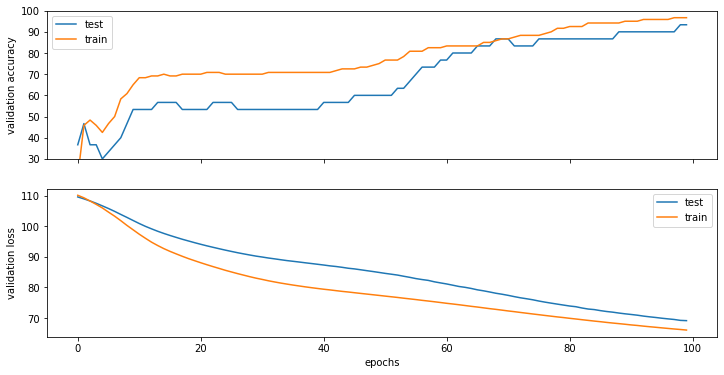

In [6]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.set_ylim([30,100])
ax1.plot(test_accuracy_list, label = 'test')
ax1.plot(train_accuracy_list, label = 'train')
ax1.set_ylabel("validation accuracy")
ax2.plot(test_loss_list, label = 'test')
ax2.plot(train_loss_list, label = 'train')
ax1.legend()
ax2.legend()
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");